Find collocations with typhon
=============================

In [17]:
import cartopy.crs as projections
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import xarray as xr

from typhon.plots import worldmap
from typhon.collocations import Collocator, expand, collapse
from typhon.files import FileSet, NetCDF4
from typhon.collocations import Collocations

Collocations between two data arrays
------------------------------------

Let's try out the simplest case: You have two xarray datasets with
temporal-spatial data and you want to find collocations between them.

At first, we create two example xarray datasets with faked measurements. Let's
assume, these data arrays represent measurements from two different instruments
(e.g. on satellites). Each measurement has a time attribute indicating when
it was taken and a geo-location (latitude and longitude) indicating where
this happened. Note that the `lat` and `lon` variables must share their first
dimension with the `time` coordinate.

In [18]:
# Create the data
primary = xr.Dataset(
    coords={
        "lat": (('along_track'), 30.*np.sin(np.linspace(-3.14, 3.14, 24))+20),
        "lon": (('along_track'), np.linspace(0, 90, 24)),
        "time": (('along_track'), np.arange("2018-01-01", "2018-01-02", dtype="datetime64[h]")),
    },
    data_vars={
        "Temperature": (("along_track"), np.random.normal(290, 5, (24))),
    }
)
secondary = xr.Dataset(
    coords={
        "lat": (('along_track'), 30.*np.sin(np.linspace(-3.14, 3.14, 24)+1.)+20),
        "lon": (('along_track'), np.linspace(0, 90, 24)),
        "time": (('along_track'), np.arange("2018-01-01", "2018-01-02", dtype="datetime64[h]")),
    },
    data_vars={
        "Temperature": (("along_track"), np.random.normal(290, 5, (24))),
    }
)

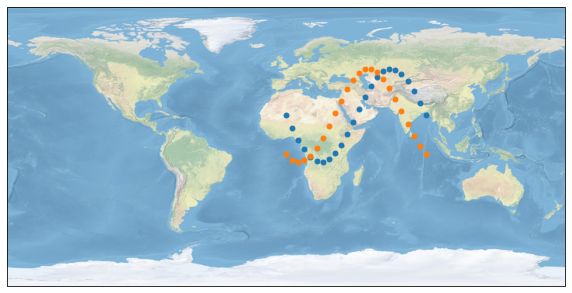

In [19]:
# Plot the data
fig = plt.figure(figsize=(10, 10))
wmap = worldmap(primary["lat"], primary["lon"], s=24, bg=True)
worldmap(secondary["lat"], secondary["lon"], s=24, ax=wmap.axes,)

Now, let’s find all measurements of primary that have a maximum distance of 300 kilometers to the measurements of secondary:

In [20]:
collocator = Collocator(name='primary_secondary_collocator')
collocations = collocator.collocate(
    primary=('primary', primary),
    secondary=('secondary', secondary),
    max_distance=600, # collocation radius in km
)
print(f'Found collocations are {collocations["Collocations/distance"].values} km apart')

Found collocations are [508.35256421  73.54718224 572.97223648 367.84317754 323.94833761
 596.11420122 295.60939811 503.38751929] km apart


In [21]:
collocations

<xarray.Dataset>
Dimensions:                (primary/collocation: 4, secondary/collocation: 5, Collocations/group: 2, Collocations/collocation: 8)
Coordinates:
    primary/lat            (primary/collocation) float64 -6.651 -9.378 ... 48.26
    primary/lon            (primary/collocation) float64 15.65 19.57 58.7 62.61
    primary/time           (primary/collocation) datetime64[ns] 2018-01-01T04...
    secondary/lat          (secondary/collocation) float64 -9.068 ... 49.81
    secondary/lon          (secondary/collocation) float64 11.74 15.65 ... 54.78
    secondary/time         (secondary/collocation) datetime64[ns] 2018-01-01T...
  * Collocations/group     (Collocations/group) <U9 'primary' 'secondary'
Dimensions without coordinates: primary/collocation, secondary/collocation, Collocations/collocation
Data variables:
    primary/Temperature    (primary/collocation) float64 295.1 289.1 291.3 283.7
    secondary/Temperature  (secondary/collocation) float64 288.8 290.9 ... 294.9
    Collocations/pairs     (Collocations/group, Collocations/collocation) int64 ...
    Collocations/interval  (Collocations/collocation) timedelta64[ns] 01:00:0...
    Collocations/distance  (Collocations/collocation) float64 508.4 ... 503.4
Attributes:
    start_time:  2018-01-01 04:00:00
    end_time:    2018-01-01 16:00:00

The obtained `collocations` dataset contains variables of 3 groups: `primary`, `secondary` and `Collocations`.
The first two correspond to the variables of the two respective input datasets and contain only the matched 
data points. The `Collocations` group adds some new variables containing information about the collocations, e.g.
the temporal and spatial distances. Additional information can be found in the [typhon documentation](https://arts.mi.uni-hamburg.de/misc/typhon/doc-trunk/generated/typhon.collocations.Collocator.collocate.html?highlight=collocations)


Let’s mark the collocations with red crosses on the map:

In [22]:
def collocations_wmap(collocations):
    fig = plt.figure(figsize=(10, 10))

    # Plot the collocations
    wmap = worldmap(
        collocations['primary/lat'],
        collocations['primary/lon'],
        facecolor="r", s=128, marker='x', bg=True
    )
    worldmap(
        collocations['secondary/lat'],
        collocations['secondary/lon'],
        facecolor="r", s=128, marker='x', bg=True, ax=wmap.axes
    )

    # Plot all points:
    worldmap(primary["lat"], primary["lon"], s=24, ax=wmap.axes,)
    worldmap(secondary["lat"], secondary["lon"], s=24, ax=wmap.axes,)
    wmap.axes.set(ylim=[-15, 55], xlim=[-10, 100])

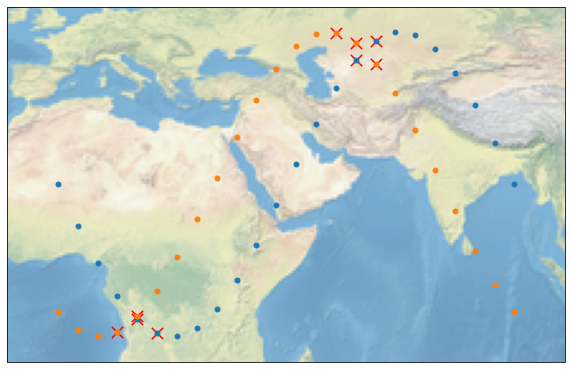

In [23]:
collocations_wmap(collocations)

We can also add a temporal filter that filters out all points which difference in time is bigger than a time interval. We are doing this by using max_interval. Note that our testdata is sampled very sparsely in time.

Found collocations are [73.54718224] km apart in space and [0] hours apart in time.


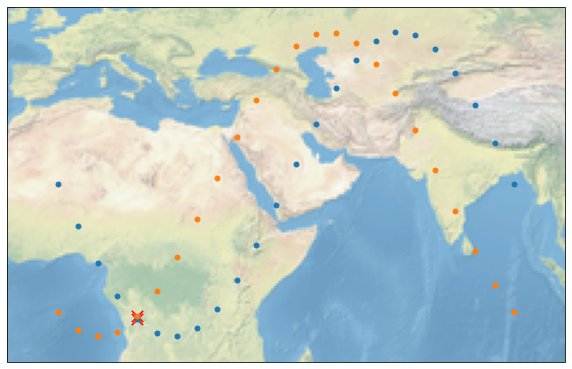

In [24]:
collocations = collocator.collocate(
    primary=('primary', primary),
    secondary=('secondary', secondary),
    max_distance=300, # collocation radius in km
    max_interval=timedelta(hours=1), # temporal collocation interval as timedelta
)
print(
    f'Found collocations are {collocations["Collocations/distance"].values} km apart in space '
    f'and {collocations["Collocations/interval"].values} hours apart in time.'
)
collocations_wmap(collocations)

As mentioned in :func:`collocate`, the collocations are returned in `compact` format, e.g. an efficient way to store the collocated data. When several data points in the `secondary` group collocate with a single observation of the `primary` group, it is not obvious how this should be handled. The `compact` format accounts for this by introducing the `Collocations/pairs` variable, which contains the respective indices of the collocated datapoints. This might not be the most practical solution 

In practice, the two functions `expand` and `collapse` offer two convenient ways to handle this. 

Applying `expand` to the collocations will repeat data points for cases where one datapoint matches with several data points of the other dataset.

In [25]:
expand(collocations)

<xarray.Dataset>
Dimensions:                (collocation: 1, Collocations/group: 2)
Coordinates:
    primary/lat            (collocation) float64 -6.651
    primary/lon            (collocation) float64 15.65
    primary/time           (collocation) datetime64[ns] 2018-01-01T04:00:00
    secondary/lat          (collocation) float64 -5.99
    secondary/lon          (collocation) float64 15.65
    secondary/time         (collocation) datetime64[ns] 2018-01-01T04:00:00
  * Collocations/group     (Collocations/group) <U9 'primary' 'secondary'
  * collocation            (collocation) int64 0
Data variables:
    primary/Temperature    (collocation) float64 295.1
    secondary/Temperature  (collocation) float64 290.9
    Collocations/interval  (collocation) timedelta64[ns] 00:00:00
    Collocations/distance  (collocation) float64 73.55
Attributes:
    start_time:  2018-01-01 04:00:00
    end_time:    2018-01-01 04:00:00

Applying `collapse` to the collocations will calculate some generic statistics (mean, std, count) over the datapoints that match with a single data point of the other dataset.

In [26]:
collapse(collocations)

<xarray.Dataset>
Dimensions:                       (collocation: 1)
Dimensions without coordinates: collocation
Data variables:
    primary/Temperature           (collocation) float64 295.1
    lat                           (collocation) float64 -6.651
    lon                           (collocation) float64 15.65
    time                          (collocation) datetime64[ns] 2018-01-01T04:...
    secondary/Temperature_mean    (collocation) float64 290.9
    secondary/Temperature_std     (collocation) float64 0.0
    secondary/Temperature_number  (collocation) int64 1
Attributes:
    start_time:  2018-01-01 04:00:00
    end_time:    2018-01-01 04:00:00

Purely temporal collocations are not implemented yet and attempts will raise a `NotImplementedError`.

Find collocations between two filesets
--------------------------------------
Normally, one has the data stored in a set of many files. typhon provides an object to handle those filesets (see the typhon doc). It is very simple to find collocations between them.

First, we need to create FileSet objects and let them know where to find their files:

In [27]:
fh = NetCDF4()
fh.write(secondary, 'testdata/secondary/2018/01/01/000000-235959.nc')

In [28]:
# Create the filesets objects and point them to the input files
a_fileset = FileSet(
    name="primary",
    path="testdata/primary/{year}/{month}/{day}/"
         "{hour}{minute}{second}-{end_hour}{end_minute}{end_second}.nc",
#     handler=handlers.NetCDF4,
)
b_fileset = FileSet(
    name="secondary",
    path="testdata/secondary/{year}/{month}/{day}/"
         "{hour}{minute}{second}-{end_hour}{end_minute}{end_second}.nc",
#     handler=handlers.NetCDF4,
)

Now, we can search for collocations between `a_dataset` and `b_dataset` and store them to `ab_collocations`.

In [29]:
# Create the output dataset:
ab_collocations = Collocations(
    name="ab_collocations",
    path="testdata/ab_collocations/{year}/{month}/{day}/"
       "{hour}{minute}{second}-{end_hour}{end_minute}{end_second}.nc",   
)
ab_collocations.search(
    [a_fileset, b_fileset], start="2018", end="2018-01-02",
    max_interval=timedelta(hours=1), max_distance=300, 
)

/Users/mprange/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
-------------------------------------------------------------------------------
100% | 0:00:06 hours elapsed, 0:00:00 hours left | 1 proc running
-------------------------------------------------------------------------------



In [30]:
fh.read('testdata/primary/2018/01/01/000000-235959.nc')

<xarray.Dataset>
Dimensions:      (along_track: 24)
Coordinates:
    lat          (along_track) float64 ...
    lon          (along_track) float64 ...
    time         (along_track) datetime64[ns] ...
Dimensions without coordinates: along_track
Data variables:
    Temperature  (along_track) float64 ...